<a href="https://colab.research.google.com/github/xtianu/docencia/blob/main/UT/Test/Tirana_CV_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computer Vision - Tirana May 2025
# Final Evaluation Exercise: Complete the following exercises

## Musel Tabares

## 1. Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

Shape        : (303, 384)  (rows, cols)
Data type    : uint8
Min / Max    : 1 … 252


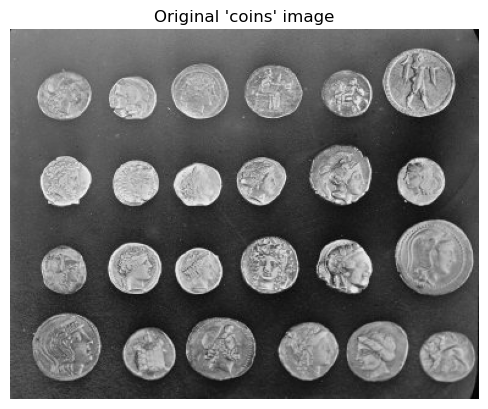

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

# load
coins = data.coins()

# basic stats
print(f"Shape        : {coins.shape}  (rows, cols)")
print(f"Data type    : {coins.dtype}")
print(f"Min / Max    : {coins.min()} … {coins.max()}")

# show
plt.figure()
plt.imshow(coins, cmap='gray')
plt.title("Original 'coins' image")
plt.axis('off')
plt.show()


We have then a 8-bit (0–255) grayscale image of size 303 × 384 pixels.

## 2. Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

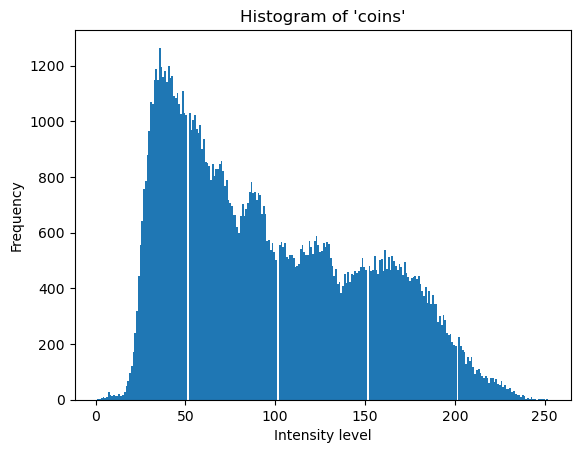

In [59]:
plt.figure()
plt.hist(coins.ravel(), bins=256)
plt.title("Histogram of 'coins'")
plt.xlabel("Intensity level")
plt.ylabel("Frequency")
plt.show()


## 3. Applied noise to the image and use the correct function to erase the noise.

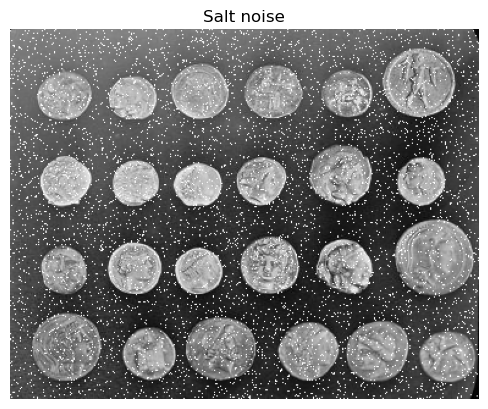

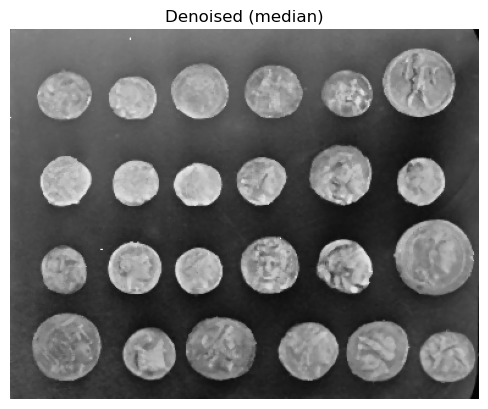

In [60]:
from skimage import util
from scipy import ndimage

noisy   = util.random_noise(coins, mode='salt', amount=0.05)          # 5 % white pixels
denoise = ndimage.median_filter(noisy, size=3)                        # 3×3 median

figures = [("Salt noise", noisy), ("Denoised (median)", denoise)]
for title, img in figures:
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


Salt noise consists of isolated white impulses; we then used a median filter that preserves edges while deleting single-pixel outliers hence smoothing and removing noise.

## 4. Segment the image using a k-means clustering algorithm with k=2 and represent the result

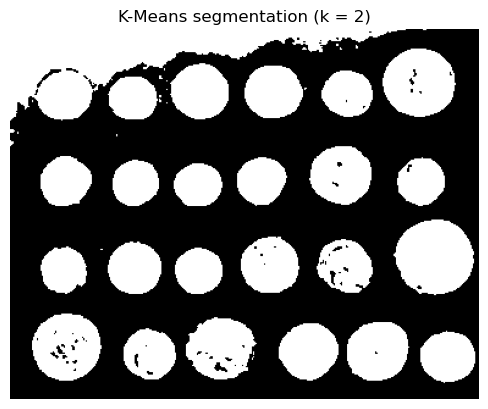

In [61]:
from sklearn.cluster import KMeans
# I will use the denoised imagefrom now on, because after aplying median filter it should be cleaner
X       = denoise.reshape(-1, 1).astype(np.float32)   # 1-D feature: intensity
labels  = KMeans(n_clusters=2, random_state=0, n_init=10).fit_predict(X)
seg     = labels.reshape(coins.shape)

plt.figure()
plt.imshow(seg, cmap='gray')
plt.title("K-Means segmentation (k = 2)")
plt.axis('off')
plt.show()


## 5. Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

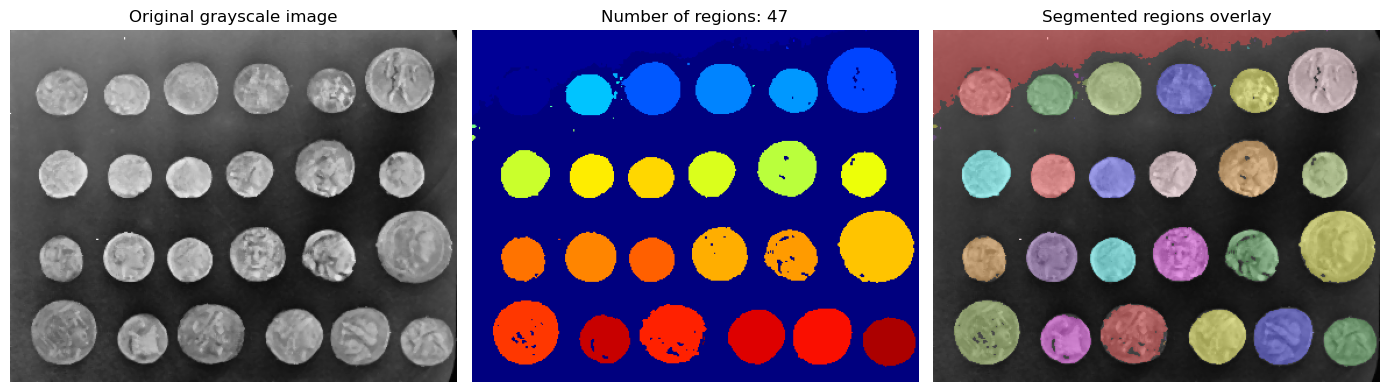

In [62]:
from skimage import morphology, measure, color
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

# Apply Otsu threshold for segmentation
thresh = threshold_otsu(denoise)
bw = denoise > thresh # keep lighter regions with grayscale intensities above threshold


# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=denoise)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(denoise,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()


## 6. Extract the area, major axis length and orientation of each coin. Report the average values of the extracted features. Represent a scatterplot of the area vs major axis length.  

In [63]:
import pandas as pd

props = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent','axis_major_length'])

df_features = pd.DataFrame(props)
df_features.head()

,label,area,eccentricity,extent,axis_major_length
0,1,9715.0,0.980413,0.394534,320.015530
1,2,2.0,1.000000,1.000000,2.000000
2,3,1.0,0.000000,1.000000,0.000000
3,4,5.0,0.958691,0.625000,4.743366
4,5,2.0,1.000000,1.000000,2.000000


<Axes: xlabel='axis_major_length', ylabel='area'>

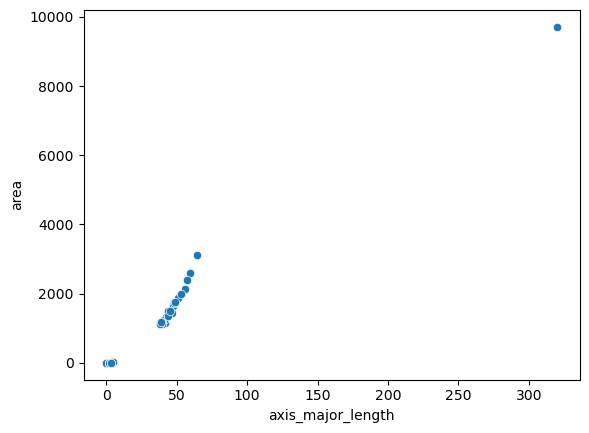

In [64]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

### Interpretation

The scatterplot reveals that the coins fall into two roughly linear clusters:
- **Small coins** (area ≈ 1400 px)
- **Big coins** (area ≈ 2000 px)

The linear relationship (regression slope) between area and major axis length indicates that the coins have a near-constant thickness, consistent with their circular shape. This suggests that both small and large coins are similarly circular, differing mainly in size.

## 7. Using the labeled regions from the 'coins' image, how can I filter the regions to find those with an area greater than 1750 pixels, count how many such coins there are?

In [65]:
mean_blobs_area = 1750
df_large_blobs = df_features.loc[df_features['area']>=mean_blobs_area]
N_large = df_large_blobs.shape[0]
print('there are {} blobs with an area larger or equal the area {}'.format(N_large,mean_blobs_area))

there are 7 blobs with an area larger or equal the area 1750


In [66]:
df_small_blobs = df_features.loc[df_features['area']<mean_blobs_area]
N_small = df_small_blobs.shape[0]
print('there are {} blobs with an area smaller than the area {}'.format(N_small,mean_blobs_area))

there are 40 blobs with an area smaller than the area 1750


In [67]:
labels_small = df_small_blobs['label'].values
print('labels of small blobs: {}'.format(labels_small))
labels_large = df_large_blobs['label'].values
print('labels of large blobs: {}'.format(labels_large))


labels of small blobs: [ 2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 28 29 30 31 32 34 35 36 37 38 39 43 44 45 46 47]
labels of large blobs: [ 1  9 27 33 40 41 42]


Now we have amount and the labels of both the small and the large blobs

In [68]:
import numpy as np
mask_small_blobs = np.isin(label_image,labels_small)
mask_large_blobs = np.isin(label_image,labels_large)

With this, now we have two arrays that indicates wether the region belongs to small or large blob. Depending whether the boolen value is true or false in either array.

## 8. Generate a 3-panel figure with the original image, the image with the little coins < 1750 coins (red color) and an image with the big coins > 1750 (blue color).

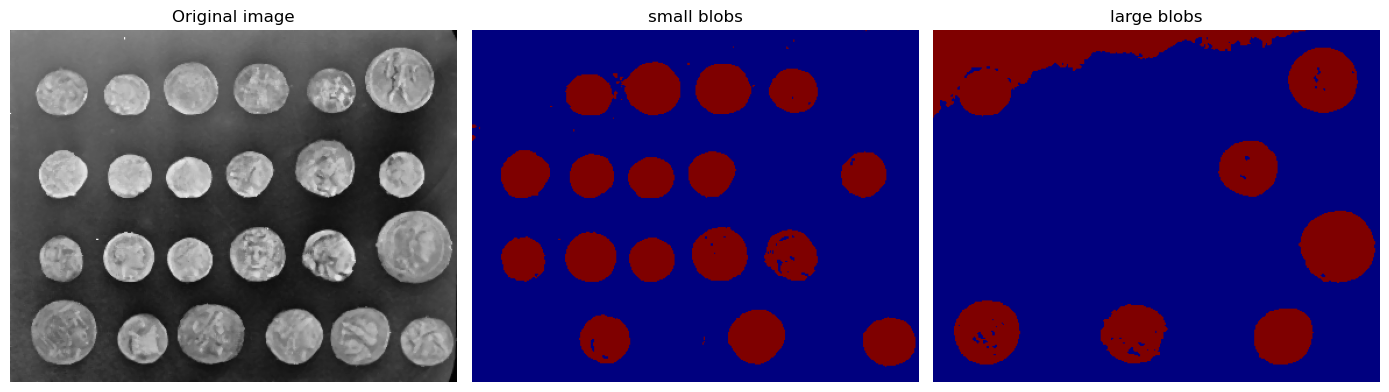

In [69]:
# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(denoise,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(mask_small_blobs,cmap=plt.cm.jet)
ax[1].set_title('small blobs') # set figure title
ax[2].imshow(mask_large_blobs,cmap=plt.cm.jet)
ax[2].set_title('large blobs')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

## 9. Describe the main steps required to perform  segmentation of an RGB image using an unsupervised clustering algorithm (use other algorithms different than K-Means and compare the results)

First Load and reshape the image, for make it an array so it can be read by sklearn methods

Then, applying other clustering algorithm, in our case it will be aglomerative clustering

Normally in this class we use clustering algorithms from sklearn.cluster library


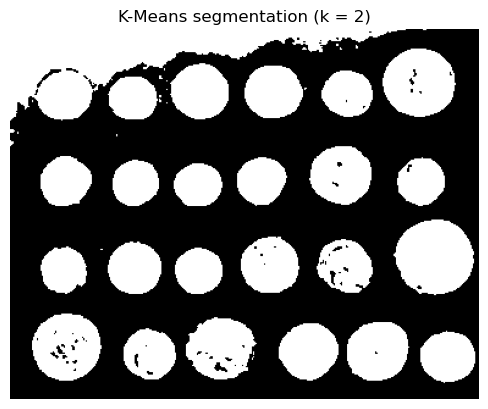

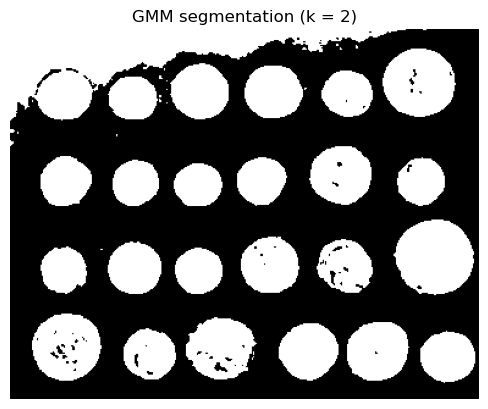

In [91]:
from sklearn.cluster import KMeans
from sklearn import mixture

# I will use the denoised imagefrom now on, because after aplying median filter it should be cleaner
X       = denoise.reshape(-1, 1).astype(np.float32)   # 1-D feature: intensity

labels  = KMeans(n_clusters=2, random_state=0, n_init=10).fit_predict(X)
labels_gmm = mixture.GaussianMixture(n_components=2).fit(X) # Fit a GMM model

seg     = labels.reshape(coins.shape)
seg_gmm    = labels.reshape(coins.shape)

plt.figure()
plt.imshow(seg, cmap='gray')
plt.title("K-Means segmentation (k = 2)")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(seg_gmm, cmap='gray')
plt.title("GMM segmentation (k = 2)")
plt.axis('off')
plt.show()

As we can see both methods GMM and K-means lead very similar results in this case, but it can vary significantly depending the case.

## 10. Extract the main texture features of this image

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops
from skimage import img_as_ubyte

# Suponiendo que tienes:
# - `IG`: imagen en escala de grises normalizada (float o uint8)
# - `label_image`: imagen segmentada (mismo tamaño que IG)

props = regionprops(label_image, intensity_image=denoise)
nregions = len(props)

props_texture = np.zeros((nregions, 5))
for i, p in enumerate(props):
    minr, minc, maxr, maxc = p.bbox
    I = denoise[minr:maxr, minc:maxc]

    # Convertir a uint8 y escalar valores si es necesario
    Iu8 = img_as_ubyte(I)

    # Calcular GLCM
    g = graycomatrix(Iu8, distances=[1], angles=[0], levels=256, normed=True, symmetric=True)

    # Extraer características
    props_texture[i, 0] = graycoprops(g, 'contrast')[0, 0]
    props_texture[i, 1] = graycoprops(g, 'dissimilarity')[0, 0]
    props_texture[i, 2] = graycoprops(g, 'homogeneity')[0, 0]
    props_texture[i, 3] = graycoprops(g, 'energy')[0, 0]
    props_texture[i, 4] = graycoprops(g, 'correlation')[0, 0]

# Exportar a Excel
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("Texture_features.xlsx", index=False)
df


,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,110.769472,3.897385,0.521889,0.047580,0.951966
1,0.000000,0.000000,1.000000,1.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000,1.000000
3,1.666667,1.000000,0.566667,0.333333,0.777778
4,0.000000,0.000000,1.000000,1.000000,1.000000
5,0.000000,0.000000,0.000000,0.000000,1.000000
6,0.000000,0.000000,0.000000,0.000000,1.000000
7,2.000000,1.000000,0.600000,0.612372,-0.333333
8,368.025726,10.031780,0.311100,0.030925,0.894729
9,192.852609,6.158696,0.379428,0.044336,0.922748


## Personal discussion

Provide a thoughtful reflection on the Computer Vision course, including your perspective on the knowledge you have acquired and your opinion about the professor. (Thank you very much for your feedback!)

I appreciate the class a lot. I love computer vision, and love how insightful the class was. I was amazed in the amount of material we covered in such short period of time.  I just can say, thank you very much for the class.